In [1]:
# import sys
# !{sys.executable} -m pip install ing_theme_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import qbstyles
# from ing_theme_matplotlib import mpl_style
import glacierml as gl
from tqdm import tqdm

# Step 1: Organize the data

## A. Load and organize the Glathida dataset

In [2]:
# raw_dataset = pd.read_csv('/data/fast0/datasets/glathida-3.1.0/data/T.csv')
TT = pd.read_csv('/home/sa42/data/glac/T_models/TT.csv')
TT = TT[[
    'LOWER_BOUND',
    'UPPER_BOUND',
    'AREA',
    'MEAN_SLOPE',
    'MEAN_THICKNESS',
    'MAXIMUM_THICKNESS',
]]
glathida = TT
glathida = glathida.dropna()

### separate out features - what will be trained to predict desired attribute

In [3]:
train_dataset = glathida.sample(frac=0.8, random_state=0)
test_dataset = glathida.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

#define label - attribute training to be picked
train_labels = train_features.pop("MAXIMUM_THICKNESS")
test_labels = test_features.pop("MAXIMUM_THICKNESS")

train_features.describe().transpose()[['mean', 'std']]

,mean,std
LOWER_BOUND,3205.591270,825.956760
UPPER_BOUND,3254.769841,841.514265
AREA,0.173664,0.356148
MEAN_SLOPE,24.015873,11.599206
MEAN_THICKNESS,22.091270,21.467747


# Step 2: Setup the Model

### Establish normalization layers

In [4]:
normalizer = {}
variable_list = list(train_features)
for variable_name in tqdm(variable_list):

    normalizer[variable_name] = gl.preprocessing.Normalization(input_shape=[1,], axis=None)
    normalizer[variable_name].adapt(np.array(train_features[variable_name]))
    
    
normalizer['ALL'] = gl.preprocessing.Normalization(axis=-1)
normalizer['ALL'].adapt(np.array(train_features))

  0%|          | 0/5 [00:00<?, ?it/s]2022-03-18 22:06:42.458207: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-18 22:06:42.458249: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sermeq.ess.washington.edu): /proc/driver/nvidia/version does not exist
2022-03-18 22:06:42.458663: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
100%|██████████| 5/5 [00:01<00:00,  3.70it/s]


In [5]:
test_results = {}
linear_model = {}
linear_history = {}
linear_results = {}

# Linear regression

In [6]:
%%time
for variable_name in tqdm(variable_list):

    linear_model[variable_name] = gl.build_linear_model(normalizer[variable_name])
    linear_history[variable_name] = linear_model[variable_name].fit(
                                        train_features[variable_name], train_labels,        
                                        epochs=1000,
                                        verbose=0,
                                        validation_split = 0.2)
    
    
    linear_results[variable_name] = linear_model[variable_name].evaluate(
                                        test_features[variable_name],
                                        test_labels, verbose=0)

linear_results

100%|██████████| 5/5 [04:58<00:00, 59.60s/it]

CPU times: user 4min 45s, sys: 2min 37s, total: 7min 22s
Wall time: 4min 58s


{'LOWER_BOUND': 33.98426818847656,
 'UPPER_BOUND': 33.77191925048828,
 'AREA': 38.55299758911133,
 'MEAN_SLOPE': 36.640377044677734,
 'MEAN_THICKNESS': 9.334268569946289}

In [7]:
for variable_name in variable_list:    
    df = pd.DataFrame(linear_history[variable_name].history)
    dfs = df.loc[[df.last_valid_index()]]
    dfs.insert(0, 'Variable', [variable_name])
    
    print(dfs)
    print('')


        Variable       loss   val_loss
999  LOWER_BOUND  25.905025  25.221991

        Variable      loss   val_loss
999  UPPER_BOUND  25.72998  24.944511

    Variable       loss   val_loss
999     AREA  32.344421  23.512552

       Variable       loss  val_loss
999  MEAN_SLOPE  29.523169  25.07177

           Variable      loss   val_loss
999  MEAN_THICKNESS  8.300606  10.916856



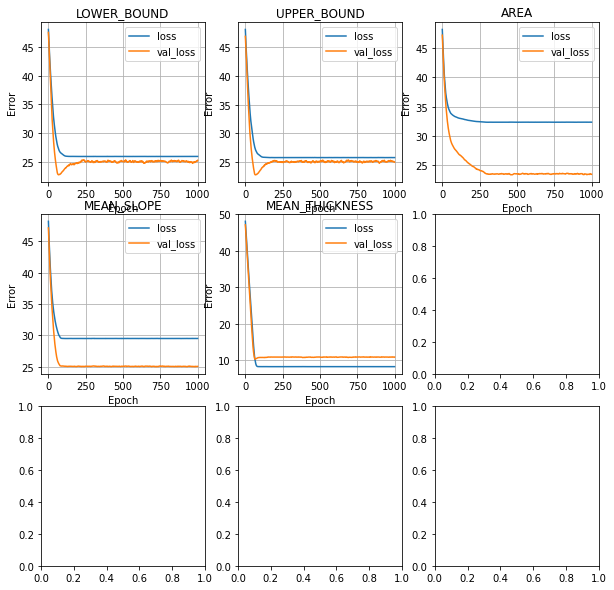

In [8]:
fig,ax = plt.subplots(3,3,figsize=(10,10))
for i, variable_name in enumerate(variable_list):
#     mpl_style("dark")
    ax = plt.subplot(3,3,i+1)
    plt.subplot(3,3,i+1)
    gl.plot_loss(linear_history[variable_name])
    ax.set_title(variable_name)
#     plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_loss.eps")

# Linear regression with multiple inputs

In [9]:
linear_model = gl.build_linear_model(normalizer['ALL'])

history_full = linear_model.fit(
train_features, train_labels,        
   epochs=1000,
   verbose=0,
   validation_split = 0.2)

test_results['MULTI'] = linear_model.evaluate(
    test_features,
    test_labels, verbose=0)

test_results

{'MULTI': 8.469441413879395}

In [10]:
df = pd.DataFrame(history_full.history)
dfs = df.loc[[df.last_valid_index()]]
dfs.insert(0, 'Variable', 'Multi-Variable')
    
print(dfs)



           Variable      loss   val_loss
999  Multi-Variable  7.951478  10.772176


<function glacierml.plot_loss(history)>

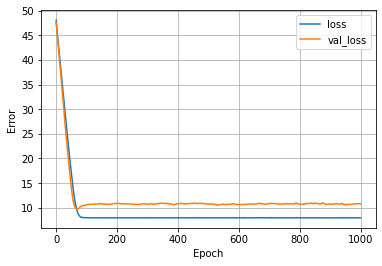

In [11]:
gl.plot_loss(history_full)
# plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_full_loss.eps")

# DNN regression

In [12]:
test_results = {}
dnn_model = {}
dnn_history = {}
dnn_results = {}

In [13]:
for variable_name in tqdm(variable_list):

    dnn_model[variable_name] = gl.build_dnn_model(normalizer[variable_name])
    dnn_history[variable_name] = dnn_model[variable_name].fit(
                                        train_features[variable_name], train_labels,        
                                        epochs=1000,
                                        verbose=0,
                                        validation_split = 0.2)
    dnn_results[variable_name] = dnn_model[variable_name].evaluate(
                                        test_features[variable_name],
                                        test_labels, verbose=0)

dnn_results

100%|██████████| 5/5 [05:22<00:00, 64.44s/it]


{'LOWER_BOUND': 30.99298858642578,
 'UPPER_BOUND': 31.729326248168945,
 'AREA': 28.731403350830078,
 'MEAN_SLOPE': 35.19810104370117,
 'MEAN_THICKNESS': 9.782265663146973}

In [14]:
for variable_name in variable_list:    
    df = pd.DataFrame(dnn_history[variable_name].history)
    dfs = df.loc[[df.last_valid_index()]]
    dfs.insert(0, 'Variable', [variable_name])
    
    print(dfs)
    print('')


        Variable       loss   val_loss
999  LOWER_BOUND  24.433149  23.028622

        Variable       loss  val_loss
999  UPPER_BOUND  24.626667  23.89345

    Variable       loss   val_loss
999     AREA  21.514868  23.106094

       Variable       loss   val_loss
999  MEAN_SLOPE  26.962685  28.266157

           Variable      loss  val_loss
999  MEAN_THICKNESS  8.514997  11.66609



In [15]:
# fig,ax=plt.subplots(2,2,figsize=(10,10))
# for i, variable_name in enumerate(variable_list):
#     plt.subplot(2,2,i+1)
#     xmax = np.max(train_features[variable_name])
#     xmin = np.min(train_features[variable_name])
#     x = tf.linspace(xmin, xmax, 101)
#     y = dnn_model[variable_name].predict(x)
#     gl.plot_single_model_variable(x,y,variable_name)

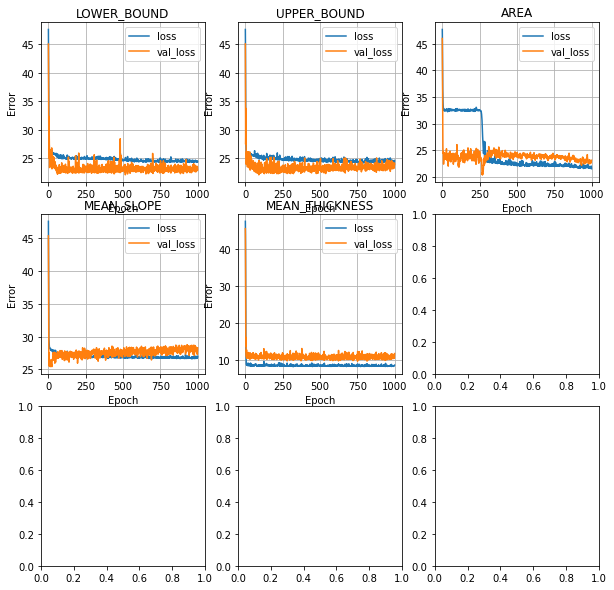

In [16]:
fig,ax=plt.subplots(3,3,figsize=(10,10))
for i, variable_name in enumerate(variable_list):
    ax = plt.subplot(3,3,i+1)
    gl.plot_loss(dnn_history[variable_name])
    ax.set_title(variable_name)
#     plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_dnn_loss.eps")

# Full model

In [17]:
dnn_full_model = gl.build_dnn_model(normalizer['ALL'])

In [18]:
%%time
dnn_history_full = dnn_full_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=1000)

CPU times: user 1min 20s, sys: 42.2 s, total: 2min 2s
Wall time: 1min 2s


In [19]:
df = pd.DataFrame(dnn_history_full.history)
dfs = df.loc[[df.last_valid_index()]]
dfs.insert(0, 'Variable', 'Multi-Variable')
    
print(dfs)


           Variable      loss  val_loss
999  Multi-Variable  3.440748  9.935476


<function glacierml.plot_loss(history)>

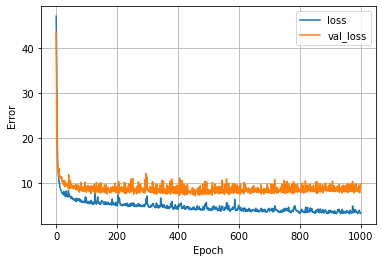

In [20]:
gl.plot_loss(dnn_history_full)
# plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_dnn_full_loss.png")

(0.0, 200.0)

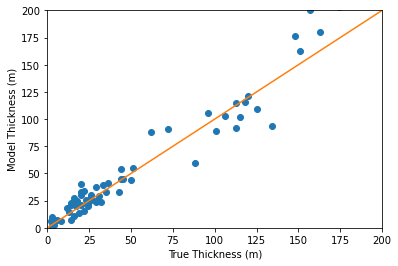

In [21]:
y = dnn_full_model.predict(test_features)
plt.plot(test_labels,y,'o')
plt.plot((0,200),(0,200),'-')
plt.xlabel('True Thickness (m)')
plt.ylabel('Model Thickness (m)')
plt.xlim((0,200))
plt.ylim((0,200))
# plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_res.EPS")